# II. EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2

In [2]:
# Read all 3 dataset

# Read Laboratory Result as labresult
path = 'data/lab.csv'
lab = pd.read_csv(path)
display(lab.head(2))

,PATIENTUNITSTAYID,UNITDISCHARGESTATUS,INTERVAL,ALBUMIN_MEDIAN,BUN_MEDIAN,T_BILIRUBIN_MEDIAN,BICARBONATE_MEDIAN,BANDS_MEDIAN,LACTATE_MEDIAN,CHLORIDE_MEDIAN,CREATININE_MEDIAN,GLUCOSE_MEDIAN,HGB_MEDIAN,HCT_MEDIAN,PLATELETSX1000_MEDIAN,POTASSIUM_MEDIAN,PTT_MEDIAN,SODIUM_MEDIAN,WBC_MEDIAN
0,141194,Alive,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141194,Alive,72,NaN,30.0,NaN,25.0,NaN,NaN,107.0,1.97,107.0,8.4,25.0,142.0,3.3,NaN,141.0,4.4


In [3]:
# Read patient as patient
path = 'data/patient.csv'
patient = pd.read_csv(path)
display(patient.head(2))

,PATIENTUNITSTAYID,AGE,GENDER,ETHNICITY,UNITDISCHARGEOFFSET,UNITDISCHARGESTATUS
0,141194,68,Male,Caucasian,4813,Alive
1,141233,81,Female,Caucasian,15685,Alive


In [4]:
# Read Vital Signs as vital
path = 'data/vt.csv'
vital = pd.read_csv(path)
display(vital.head(2))

,PATIENTUNITSTAYID,UNITDISCHARGESTATUS,INTERVAL,TEMPERATURE_MEDIAN,HEARTRATE_MEDIAN,RESPIRATION_MEDIAN,MEAN_ARTERIAL_PRESSURE_MEDIAN,PERIPHERALOXY_MEDIAN,SYSTEM_SYSTOLIC,SYSTEM_DIASTOLIC
0,141194,Alive,57,NaN,107.0,20.5,NaN,100.0,98.0,44.0
1,141194,Alive,58,NaN,113.0,18.5,NaN,100.0,98.0,44.0


In [5]:
# Lower all column names and adjust some column names for better understanding
dataframes = [lab, vital, patient]

for df in dataframes:
    df.columns = df.columns.str.lower()
    df.rename(columns={'unitdischargeoffset': 'icu_duration_days', 'unitdischargestatus': 'patient_status'}, inplace=True)
    df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90018 entries, 0 to 90017
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   patientunitstayid      90018 non-null  int64  
 1   patient_status         90010 non-null  object 
 2   interval               90018 non-null  int64  
 3   albumin_median         13915 non-null  float64
 4   bun_median             40198 non-null  float64
 5   t_bilirubin_median     11558 non-null  float64
 6   bicarbonate_median     38197 non-null  float64
 7   bands_median           2336 non-null   float64
 8   lactate_median         2451 non-null   float64
 9   chloride_median        40385 non-null  float64
 10  creatinine_median      40293 non-null  float64
 11  glucose_median         40369 non-null  float64
 12  hgb_median             38967 non-null  float64
 13  hct_median             38811 non-null  float64
 14  plateletsx1000_median  36650 non-null  float64
 15  po

## 1. Patient data

### Cleaning data

In [6]:
# Change ICU duration to be in days instead of minutes
patient['icu_duration_days'] = patient['icu_duration_days'] / (60*24)

As we see from info above, the Age dtype is object because of value >89, so correct it to round up to 90 so we can analyze easier

In [7]:
# Correct dtype for Age value
# Check value of Age
display("Before:", patient['age'].value_counts())

# Change >89 to be 90
patient['age'] = patient['age'].replace({'> 89': 90})

# Convert all value to numeric
patient['age'] = pd.to_numeric(patient['age'])

# Check value of Age
display("\nAfter:", patient['age'].value_counts())

'Before:'

> 89    1562
68      1185
67      1180
71      1151
72      1142
        ... 
14         3
2          2
1          1
5          1
11         1
Name: age, Length: 81, dtype: int64

'\nAfter:'

90    1562
68    1185
67    1180
71    1151
72    1142
      ... 
14       3
2        2
1        1
5        1
11       1
Name: age, Length: 81, dtype: int64

**Impute the missing data of categorical variable**

Checking null and found a few observation was missing the data about the gender and the ethnicity. To make sure the number of patient is aligned among 3 tables patients, vital and labresult, I will not remove but impute by using mode for gender and ethicity.

I kept the same patient_status as majority patient still alive so i will exclude those 4 patients in the summary table.

After imputing, the proportion almost remain the same.

In [8]:
patient.isnull().sum()

patientunitstayid      0
age                    0
gender                 1
ethnicity            466
icu_duration_days      0
patient_status         4
dtype: int64

In [8]:
# Impute for Gender
display(patient['gender'].value_counts(normalize=True)*100)

# Group minor cases into the bigger portion 'Male'
patient['gender'].fillna(patient['gender'].mode()[0], inplace = True)

# Group Other and Unknown together
patient['gender'].replace('Other', 'Unknown', inplace=True)
display(patient['gender'].value_counts(normalize=True)*100)

Male       55.012470
Female     44.976396
Unknown     0.008907
Other       0.002227
Name: gender, dtype: float64

Male       55.013472
Female     44.975395
Unknown     0.011134
Name: gender, dtype: float64

In [9]:
# Impute for Ethnicity
display(patient['ethnicity'].value_counts(normalize=True)*100)

# Group minor cases into the bigger portion 'Male'
patient['ethnicity'].fillna(patient['ethnicity'].mode()[0], inplace = True)
display(patient['ethnicity'].value_counts(normalize=True)*100)

Caucasian           77.769278
African American    11.313368
Other/Unknown        4.970412
Hispanic             3.667619
Asian                1.692055
Native American      0.587269
Name: ethnicity, dtype: float64

Caucasian           77.999955
African American    11.195974
Other/Unknown        4.918836
Hispanic             3.629562
Asian                1.674497
Native American      0.581175
Name: ethnicity, dtype: float64

### Summarize Patient Demographic

In [11]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44909 entries, 0 to 44908
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patientunitstayid  44909 non-null  int64  
 1   age                44909 non-null  int64  
 2   gender             44909 non-null  object 
 3   ethnicity          44909 non-null  object 
 4   icu_duration_days  44909 non-null  float64
 5   patient_status     44905 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.1+ MB


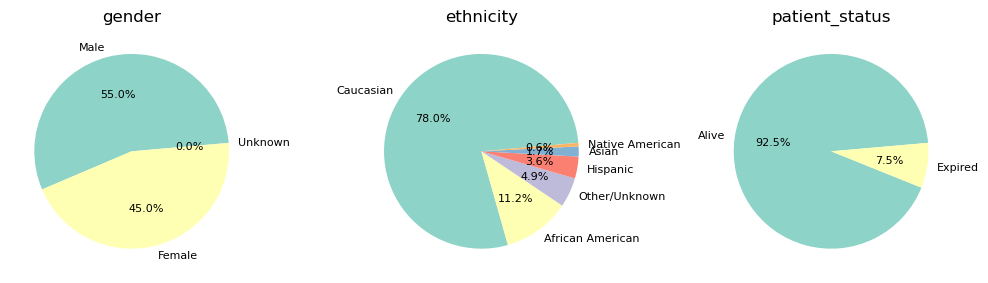

Column: gender
Unique values:
['Male' 'Female' 'Unknown']

Value counts:
Male       24706
Female     20198
Unknown        5
Name: gender, dtype: int64

--------------------------------------------------

Column: ethnicity
Unique values:
['Caucasian' 'African American' 'Asian' 'Native American' 'Hispanic'
 'Other/Unknown']

Value counts:
Caucasian           35029
African American     5028
Other/Unknown        2209
Hispanic             1630
Asian                 752
Native American       261
Name: ethnicity, dtype: int64

--------------------------------------------------

Column: patient_status
Unique values:
['Alive' 'Expired' nan]

Value counts:
Alive      41546
Expired     3359
NaN            4
Name: patient_status, dtype: int64

--------------------------------------------------



In [10]:
cat_cols =['gender', 'ethnicity', 'patient_status']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))

axes = axes.flatten()

# pie chart
for i, col in enumerate(cat_cols):
    counts = patient[col].value_counts()

    axes[i].pie(counts, labels=counts.index,
                autopct='%1.1f%%', textprops={'fontsize': 8},
                startangle=5, colors=sns.color_palette('Set3'))
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

cat_cols = ['gender', 'ethnicity', 'patient_status']
for col in cat_cols:
    print(f"Column: {col}")
    print("Unique values:")
    print(patient[col].unique())
    print("\nValue counts:")
    print(patient[col].value_counts(dropna=False))  # dropna=False to include NaN in the counts
    print("\n" + "-"*50 + "\n")

* There are more male patient than female but it is still slightly balance between both gender. Other unknown gender take less than 1%
* Mostly patient is alive after the first admission to the ICU, so we are having imbalance targeted data here.
* Caucasian is the main ethnicity in this dataset, follow by African American, Hispanic, and others

### Pivot patient demographics

In [13]:
# Calculate Patient demographics
patient_count = patient['patient_status'].value_counts()
age_mean = patient.groupby('patient_status')['age'].mean()
age_std = patient.groupby('patient_status')['age'].std()
icu_duration_std = patient.groupby('patient_status')['icu_duration_days'].std()
icu_duration_mean = patient.groupby('patient_status')['icu_duration_days'].mean()
gender_count = patient.groupby('patient_status')['gender'].value_counts().unstack().fillna(0)
ethnicity_count = patient.groupby('patient_status')['ethnicity'].value_counts().unstack().fillna(0)

# Create the summary table for the given metrics
summary_data = {
    'number_of_patients': patient_count,
    'age_mean': age_mean,
    'age_std': age_std,
    'ICU duration mean (days)': icu_duration_mean,
    'ICU duration std': icu_duration_std
}
sum_patient = pd.DataFrame(summary_data).T

# Add gender and ethnicity counts to the summary table
for gender in gender_count.columns:
    sum_patient.loc[f'gender_{gender}'] = gender_count[gender]

for ethnicity in ethnicity_count.columns:
    sum_patient.loc[f'ethnicity_{ethnicity}'] = ethnicity_count[ethnicity]

# Add column total
total_patient_count = len(patient)
total_age_mean = patient['age'].mean()
total_age_std = patient['age'].std()
total_icu_duration_mean = patient['icu_duration_days'].mean()
total_icu_duration_std = patient['icu_duration_days'].std()
total_gender_count = patient['gender'].value_counts()
total_ethnicity_count = patient['ethnicity'].value_counts()

sum_patient['Total'] = [total_patient_count, total_age_mean,total_age_std, total_icu_duration_mean,total_icu_duration_std] + \
    [total_gender_count.get(g, 0) for g in gender_count.columns] + \
    [total_ethnicity_count.get(e, 0) for e in ethnicity_count.columns]

# Display the table
display(round(sum_patient,1))

patient_status,Alive,Expired,Total
number_of_patients,41546.0,3359.0,44909.0
age_mean,64.3,66.5,64.5
age_std,16.3,15.6,16.2
ICU duration mean (days),5.8,7.8,6.0
ICU duration std,6.0,7.4,6.2
gender_Female,18704.0,1492.0,20198.0
gender_Male,22838.0,1866.0,24706.0
gender_Unknown,4.0,1.0,5.0
ethnicity_African American,4691.0,337.0,5028.0
ethnicity_Asian,692.0,60.0,752.0


## 2. Vital data

### Cleaning data

In [11]:
# Add column time_bf_discharge to see patient's record 24 hours before discharged from ICU
vital['time_bf_discharge'] = vital.groupby('patientunitstayid')['interval'].transform(lambda x: x.max() - x)

### Cleaning data

In [12]:
#Calculate % null missing per each columns and rank descending
missing_percentage = (vital.isnull().sum() / len(vital)) * 100
missing_sorted = missing_percentage.sort_values(ascending=False)
missing_sorted

mean_arterial_pressure_median    90.206407
temperature_median               81.179379
system_diastolic                 61.314897
system_systolic                  61.312571
respiration_median                5.718656
peripheraloxy_median              0.676038
heartrate_median                  0.009886
patient_status                    0.009208
patientunitstayid                 0.000000
interval                          0.000000
time_bf_discharge                 0.000000
dtype: float64

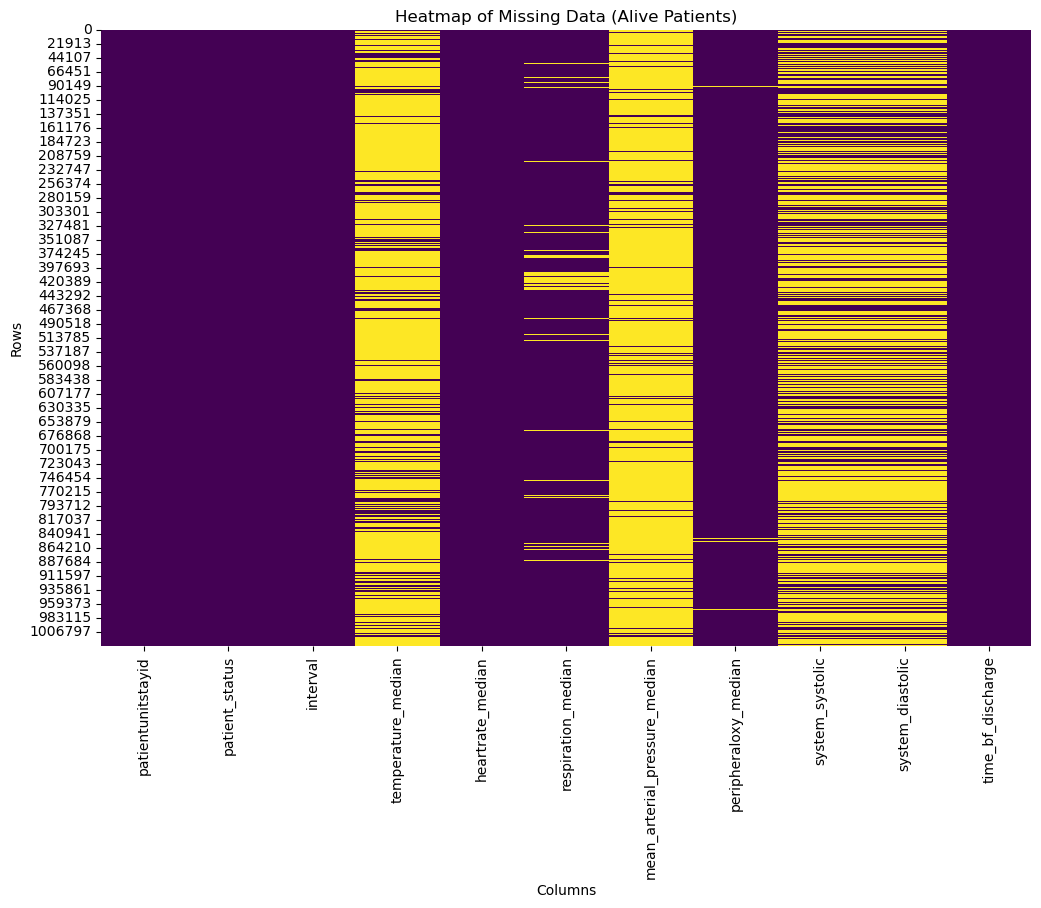

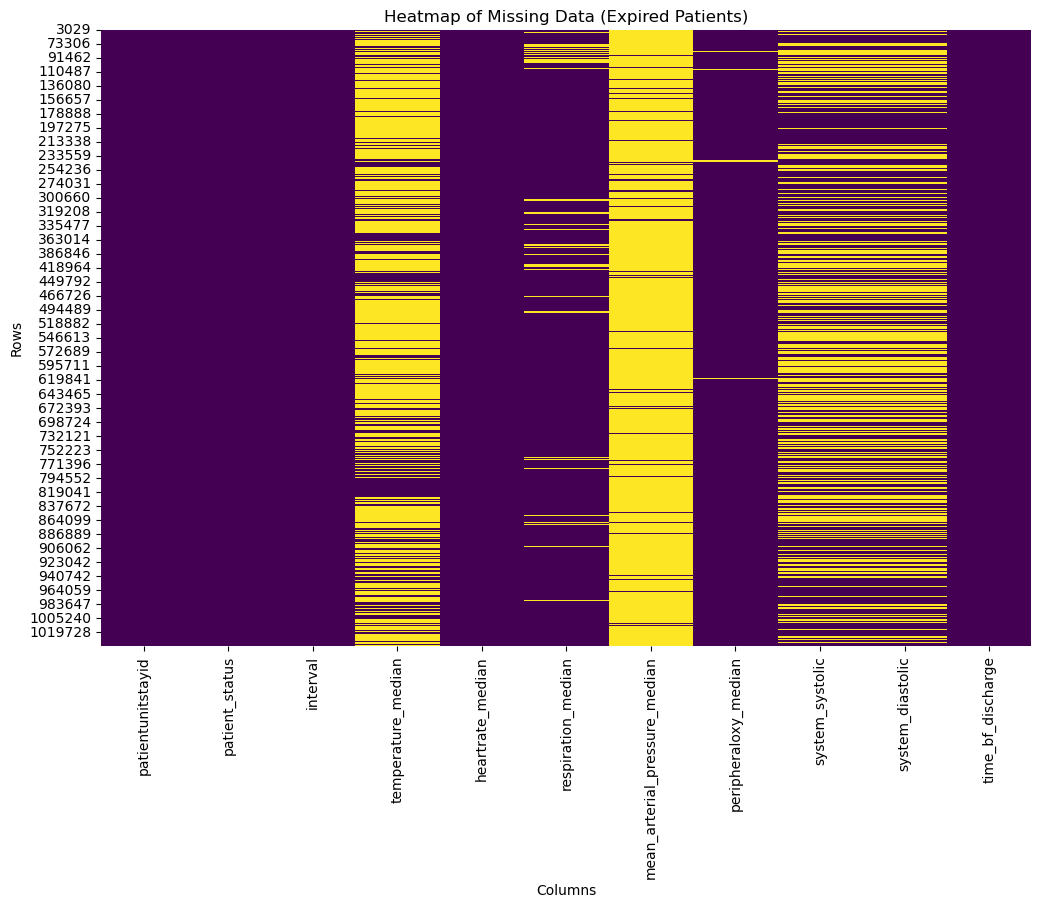

In [16]:
# Split the data based on patient status
vital_alive = vital[vital['patient_status'] == 'Alive']
vital_expired = vital[vital['patient_status'] == 'Expired']

# Plot the heatmap of missing data for patients who are alive
plt.figure(figsize=(12, 8))
sns.heatmap(vital_alive.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Alive Patients)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# Plot the heatmap of missing data for patients who have expired
plt.figure(figsize=(12, 8))
sns.heatmap(vital_expired.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Expired Patients)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

* From both heatmap, we can see the missing value happened at random.

* Temperature seems has more missing at 'Alive' patient.

* Since this is monitoring by bedside monitor, some data could be missing even we already try to impute by carry-forwar method (take the last measurement) so I will keep the data as it is.

### Preview some sample patient

In [17]:
pid = 145659 # Test with other 'Expired' patient such as 3353194, 722936 or Alive patient id: 3353213,144954
vital[vital['patientunitstayid'] == pid]  

,patientunitstayid,patient_status,interval,temperature_median,heartrate_median,respiration_median,mean_arterial_pressure_median,peripheraloxy_median,system_systolic,system_diastolic,time_bf_discharge
3029,145659,Expired,80,NaN,99.5,30.5,NaN,95.0,148.0,70.0,22
3030,145659,Expired,81,NaN,106.0,54.5,NaN,91.0,132.0,56.5,21
3031,145659,Expired,82,NaN,112.0,45.5,NaN,93.0,131.0,60.5,20
3032,145659,Expired,83,NaN,122.5,46.0,NaN,90.5,138.5,61.0,19
3033,145659,Expired,84,NaN,125.5,44.5,NaN,93.0,121.5,55.0,18
3034,145659,Expired,85,NaN,135.5,44.0,NaN,92.0,128.0,57.0,17
3035,145659,Expired,86,NaN,141.0,26.0,NaN,85.5,105.5,52.5,16
3036,145659,Expired,87,NaN,140.0,20.0,NaN,85.0,91.5,47.0,15
3037,145659,Expired,88,NaN,127.5,46.0,NaN,85.0,104.0,51.0,14
3038,145659,Expired,89,NaN,125.0,46.5,NaN,85.0,86.0,45.5,13


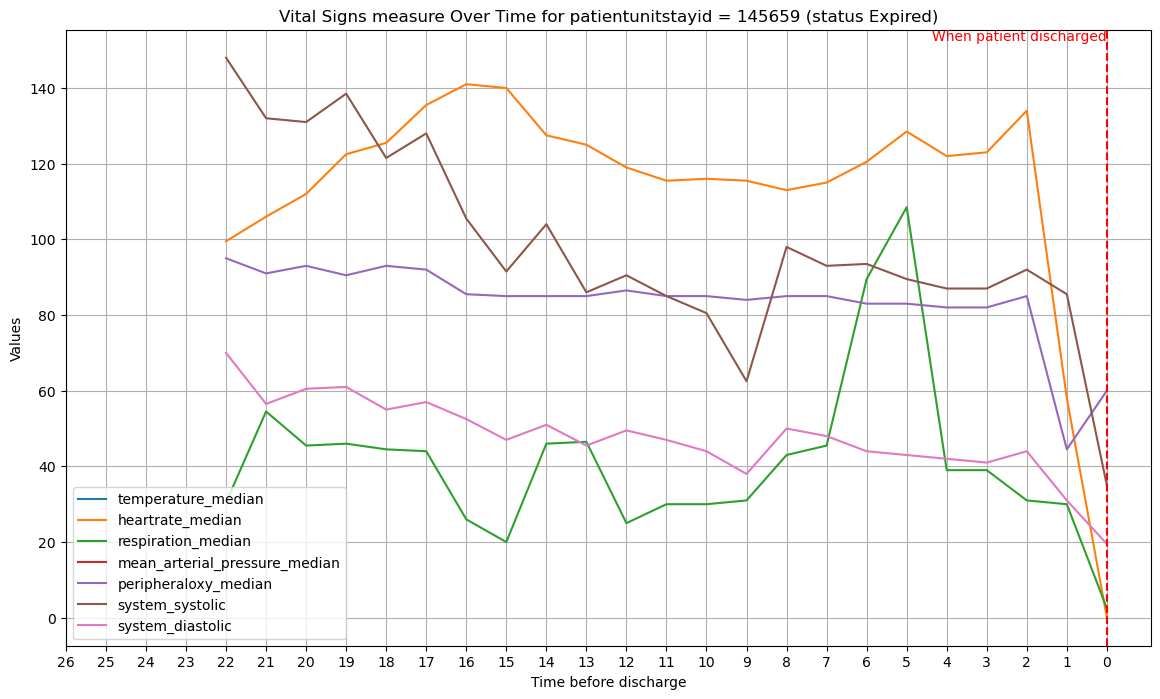

In [18]:
status = vital[vital['patientunitstayid'] == pid]['patient_status'].iloc[0]
patient_data = vital[vital['patientunitstayid'] == pid]  

# Columns to plot
vt_cols = [
    'temperature_median', 'heartrate_median', 'respiration_median',
    'mean_arterial_pressure_median', 'peripheraloxy_median', 
    'system_systolic', 'system_diastolic'
]

# Plotting the data
plt.figure(figsize=(14, 8))

for column in vt_cols:
    plt.plot(patient_data['time_bf_discharge'], patient_data[column], label=column)

# Adding the vertical line at x=0
plt.axvline(x=0, color='red', linestyle='--')
plt.text(0, plt.ylim()[1], 'When patient discharged', color='red', verticalalignment='top', horizontalalignment='right')

# Setting x-axis to display from 23 to 0
plt.gca().invert_xaxis()
plt.xticks(range(0, 27, 1))
plt.xlabel('Time before discharge')
plt.ylabel('Values')
plt.title(f'Vital Signs measure Over Time for patientunitstayid = {pid} (status {status})')
plt.legend()
plt.grid(True)
plt.show()

For example, patient 145659 (status Expired), the last hour Some vital signs drop significantly, also heart rate, respiration stop when patient pass away.

### Pivot Vital signs records

In [19]:
vital.columns

Index(['patientunitstayid', 'patient_status', 'interval', 'temperature_median',
       'heartrate_median', 'respiration_median',
       'mean_arterial_pressure_median', 'peripheraloxy_median',
       'system_systolic', 'system_diastolic', 'time_bf_discharge'],
      dtype='object')

In [17]:
# Calculate vital
vt_cols = [
    'heartrate_median', 'system_diastolic', 'system_systolic',
    'mean_arterial_pressure_median', 'temperature_median',
    'peripheraloxy_median', 'respiration_median'
    ]
sum_vt_mean = vital.groupby('patient_status')[vt_cols].median().round(1).T
sum_vt_std= vital.groupby('patient_status')[vt_cols].std().round(1).T
sum_vt = pd.concat([sum_vt_mean, sum_vt_std], axis=1)
sum_vt.columns = ['Alive', 'Expired', 'Alive(std)', 'Expired(std)']
sum_vt

,Alive,Expired,Alive(std),Expired(std)
heartrate_median,83.0,93.0,16.5,22.3
system_diastolic,64.0,55.5,39.2,26.3
system_systolic,124.0,109.0,45.2,36.5
mean_arterial_pressure_median,25.0,29.0,57.1,59.8
temperature_median,37.2,37.0,10.0,11.2
peripheraloxy_median,97.0,96.0,3.9,11.4
respiration_median,20.0,21.0,6.9,9.4


## 3. Laboratory Result data

### Cleaning data

In [21]:
# Add column time_bf_discharge to see patient's record 24 hours before discharged from ICU
lab['time_bf_discharge'] = lab.groupby('patientunitstayid')['interval'].transform(lambda x: x.max() - x)

# Crosscheck if the data include 3 values for 8-hour-interval per patient
lab['time_bf_discharge'].value_counts()

time_bf_discharge
0     42818
8     29737
16    17463
Name: count, dtype: int64

In [22]:
#Calculate % null missing per each columns and rank descending
missing_percentage = (lab.isnull().sum() / len(lab)) * 100
missing_sorted = missing_percentage.sort_values(ascending=False)
missing_sorted

bands_median             97.404963
lactate_median           97.277211
ptt_median               92.921416
t_bilirubin_median       87.160346
albumin_median           84.541980
plateletsx1000_median    59.285921
wbc_median               59.265925
bicarbonate_median       57.567375
hct_median               56.885290
hgb_median               56.711991
bun_median               55.344487
creatinine_median        55.238952
glucose_median           55.154525
chloride_median          55.136750
sodium_median            54.042525
potassium_median         50.294386
patient_status            0.008887
patientunitstayid         0.000000
interval                  0.000000
time_bf_discharge         0.000000
dtype: float64

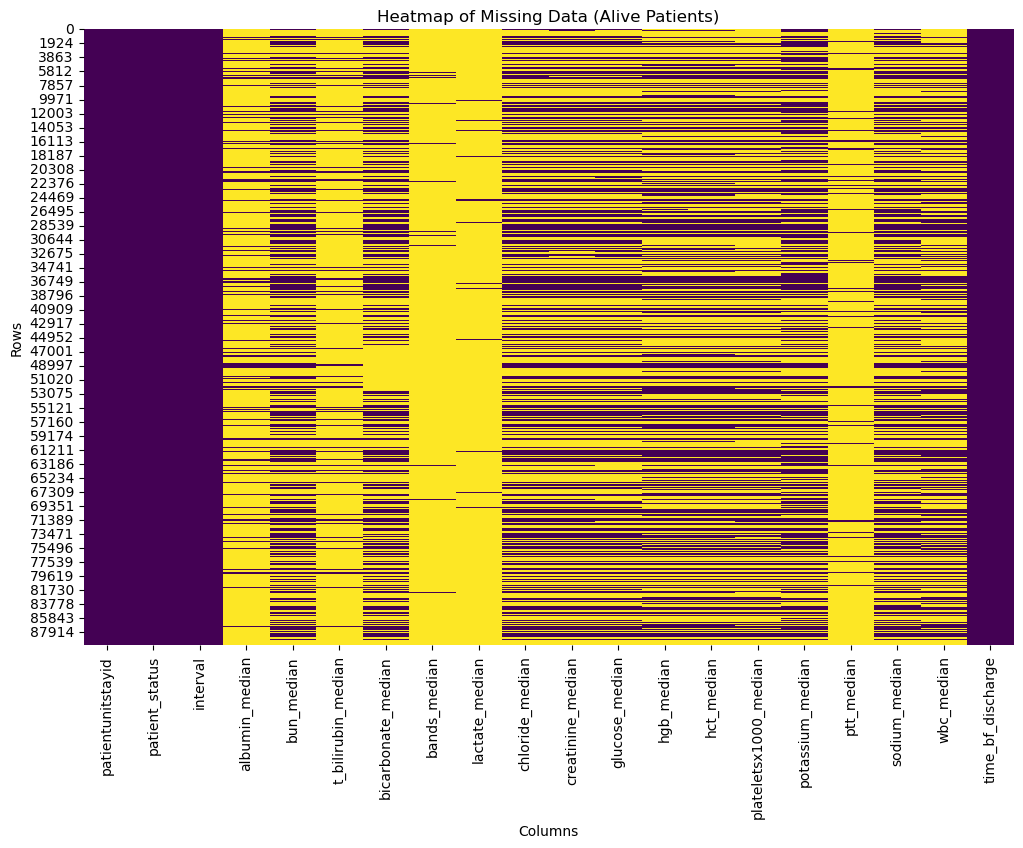

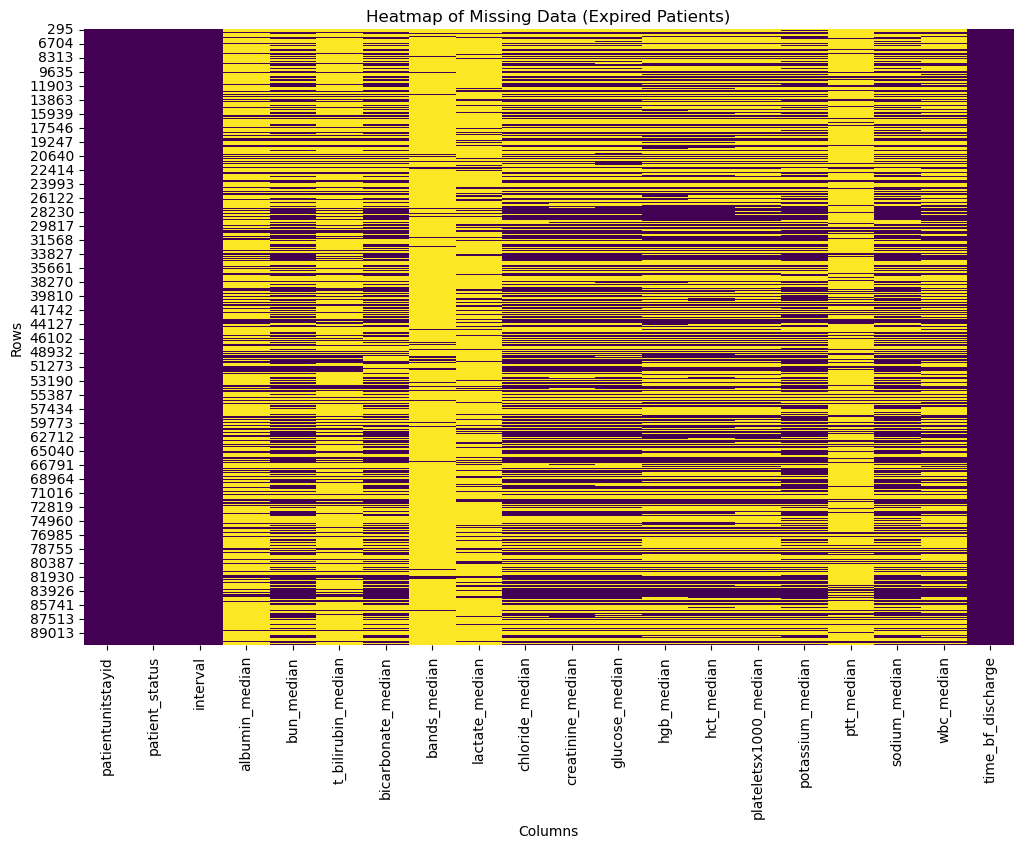

In [23]:
# Split the data based on patient status
lab_alive = lab[lab['patient_status'] == 'Alive']
lab_expired = lab[lab['patient_status'] == 'Expired']

# Plot the heatmap of missing data for patients who are alive
plt.figure(figsize=(12, 8))
sns.heatmap(lab_alive.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Alive Patients)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

# Plot the heatmap of missing data for patients who have expired
plt.figure(figsize=(12, 8))
sns.heatmap(lab_expired.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data (Expired Patients)')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

* There are no patterns I can observe from both group of patients
* Some patients seems are not appointed to take the test hence the result was all null

### Preview some sample patient

In [24]:
lab.columns

Index(['patientunitstayid', 'patient_status', 'interval', 'albumin_median',
       'bun_median', 't_bilirubin_median', 'bicarbonate_median',
       'bands_median', 'lactate_median', 'chloride_median',
       'creatinine_median', 'glucose_median', 'hgb_median', 'hct_median',
       'plateletsx1000_median', 'potassium_median', 'ptt_median',
       'sodium_median', 'wbc_median', 'time_bf_discharge'],
      dtype='object')

In [25]:
pid = 1066563 # Test with 'Expired' patient id: 463241, 476223, or 'Alive' patient id:1065865, 1066563
lab[lab['patientunitstayid'] == pid]

,patientunitstayid,patient_status,interval,albumin_median,bun_median,t_bilirubin_median,bicarbonate_median,bands_median,lactate_median,chloride_median,creatinine_median,glucose_median,hgb_median,hct_median,plateletsx1000_median,potassium_median,ptt_median,sodium_median,wbc_median,time_bf_discharge
26319,1066563,Alive,32,NaN,44.0,NaN,21.0,NaN,2.46,105.5,3.17,257.0,12.4,NaN,NaN,3.05,NaN,135.5,NaN,16
26320,1066563,Alive,40,1.8,46.0,0.6,22.0,NaN,1.86,105.0,2.97,202.0,11.5,33.2,40.0,3.80,NaN,135.0,6.6,8
26321,1066563,Alive,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,0


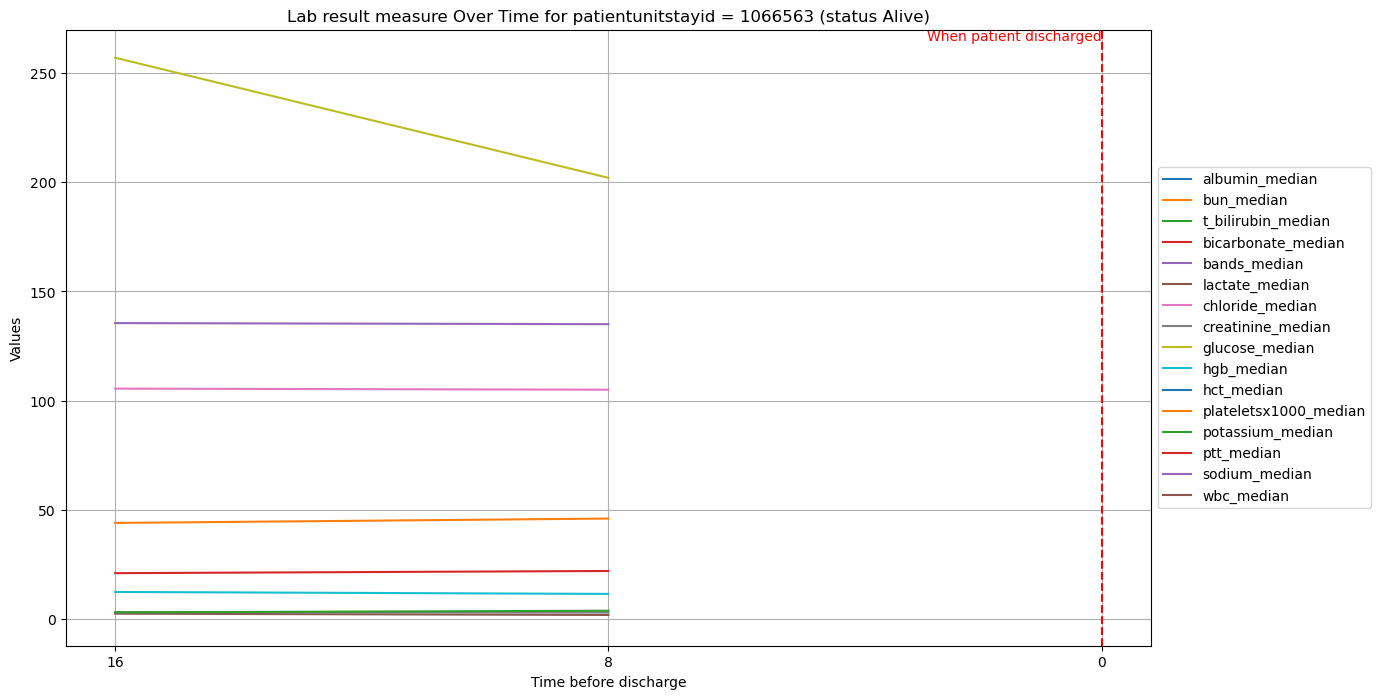

In [26]:
status = lab[lab['patientunitstayid'] == pid]['patient_status'].iloc[0]
patient_data = lab[lab['patientunitstayid'] == pid]  

# Columns to plot
lab_cols = [
    'albumin_median',
       'bun_median', 't_bilirubin_median', 'bicarbonate_median',
       'bands_median', 'lactate_median', 'chloride_median',
       'creatinine_median', 'glucose_median', 'hgb_median', 'hct_median',
       'plateletsx1000_median', 'potassium_median', 'ptt_median',
       'sodium_median', 'wbc_median'
]

# Plotting the data
plt.figure(figsize=(14, 8))

for column in lab_cols:
    plt.plot(patient_data['time_bf_discharge'], patient_data[column], label=column)

# Adding the vertical line at x=0
plt.axvline(x=0, color='red', linestyle='--')
plt.text(0, plt.ylim()[1], 'When patient discharged', color='red', verticalalignment='top', horizontalalignment='right')

# Setting x-axis to display from 16, 8 and 0 hours interval before discharge
plt.gca().invert_xaxis()
plt.xticks(range(0, 20, 8))
plt.xlabel('Time before discharge')
plt.ylabel('Values')
plt.title(f'Lab result measure Over Time for patientunitstayid = {pid} (status {status})')
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

* There are not a lot of lab result taken within 8 hours interval for the patient. It does make sense if the lab normally taking time, unless they can have result right way then we can have more frequent data for lab result. Currently most of the case, patient was appointed to take lab test just one or twice a day (per 24 hours) hence we could not see much fluctuated in the graph.

### Pivot Laboratory Result data

In [15]:
# Calculate lab result
lab_cols = ['albumin_median',
       'bun_median', 't_bilirubin_median', 'bicarbonate_median',
       'bands_median', 'lactate_median', 'chloride_median',
       'creatinine_median', 'glucose_median', 'hgb_median', 'hct_median',
       'plateletsx1000_median', 'potassium_median', 'ptt_median',
       'sodium_median', 'wbc_median'
    ]

sum_lab_mean = lab.groupby('patient_status')[lab_cols].median().round(1).T
sum_lab_sd = lab.groupby('patient_status')[lab_cols].std().round(1).T
sum_lab = pd.concat([sum_lab_mean, sum_lab_sd], axis=1)
sum_lab.columns = ['Alive', 'Expired', 'Alive(std)', 'Expired(std)']
sum_lab

,Alive,Expired,Alive(std),Expired(std)
albumin_median,2.6,2.4,0.6,0.7
bun_median,21.0,34.0,20.9,30.8
t_bilirubin_median,0.7,1.1,3.3,5.5
bicarbonate_median,26.0,22.0,4.8,6.6
bands_median,4.0,8.0,10.5,12.3
lactate_median,1.3,4.6,2.3,6.1
chloride_median,104.0,106.0,6.4,9.5
creatinine_median,0.9,1.6,1.4,1.6
glucose_median,119.0,140.0,49.2,70.7
hgb_median,9.8,9.3,2.0,2.0


# III. Prepare data for ML

## 1. Merge tables to a single df for later ML

In [13]:
display(patient.head())
display(vital.head())
display(lab.head())

,patientunitstayid,age,gender,ethnicity,icu_duration_days,patient_status
0,141194,68,Male,Caucasian,3.342361,Alive
1,141233,81,Female,Caucasian,10.892361,Alive
2,141244,59,Male,Caucasian,2.663194,Alive
3,141265,67,Male,Caucasian,4.213889,Alive
4,141304,70,Male,Caucasian,4.610417,Alive


,patientunitstayid,patient_status,interval,temperature_median,heartrate_median,respiration_median,mean_arterial_pressure_median,peripheraloxy_median,system_systolic,system_diastolic,time_bf_discharge
0,141194,Alive,57,NaN,107.0,20.5,NaN,100.0,98.0,44.0,23
1,141194,Alive,58,NaN,113.0,18.5,NaN,100.0,98.0,44.0,22
2,141194,Alive,59,NaN,100.0,19.0,NaN,99.0,98.0,44.0,21
3,141194,Alive,60,NaN,88.0,20.0,NaN,98.5,98.0,44.0,20
4,141194,Alive,61,NaN,77.0,18.0,NaN,98.5,98.0,44.0,19


,patientunitstayid,patient_status,interval,albumin_median,bun_median,t_bilirubin_median,bicarbonate_median,bands_median,lactate_median,chloride_median,creatinine_median,glucose_median,hgb_median,hct_median,plateletsx1000_median,potassium_median,ptt_median,sodium_median,wbc_median
0,141194,Alive,64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,141194,Alive,72,NaN,30.0,NaN,25.0,NaN,NaN,107.0,1.97,107.0,8.4,25.0,142.0,3.3,NaN,141.0,4.4
2,141233,Alive,240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN
3,141233,Alive,248,NaN,23.0,NaN,25.0,NaN,NaN,100.0,0.84,96.0,NaN,NaN,NaN,2.5,NaN,134.0,NaN
4,141233,Alive,256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN


In [18]:
display(lab_cols)
display(vt_cols)

['albumin_median',
 'bun_median',
 't_bilirubin_median',
 'bicarbonate_median',
 'bands_median',
 'lactate_median',
 'chloride_median',
 'creatinine_median',
 'glucose_median',
 'hgb_median',
 'hct_median',
 'plateletsx1000_median',
 'potassium_median',
 'ptt_median',
 'sodium_median',
 'wbc_median']

['heartrate_median',
 'system_diastolic',
 'system_systolic',
 'mean_arterial_pressure_median',
 'temperature_median',
 'peripheraloxy_median',
 'respiration_median']

In [20]:
# Create pivot table for Vital and Lab to aggreate the result from time series to be median only
pivot_lab = lab.groupby('patientunitstayid')[lab_cols].median().reset_index()
pivot_vt = vital.groupby('patientunitstayid')[vt_cols].median().reset_index()

# Display
display(pivot_lab.head())
display(pivot_vt.head())

,patientunitstayid,albumin_median,bun_median,t_bilirubin_median,bicarbonate_median,bands_median,lactate_median,chloride_median,creatinine_median,glucose_median,hgb_median,hct_median,plateletsx1000_median,potassium_median,ptt_median,sodium_median,wbc_median
0,141194,NaN,30.0,NaN,25.0,NaN,NaN,107.0,1.97,107.0,8.4,25.0,142.0,3.3,NaN,141.0,4.4
1,141233,NaN,23.0,NaN,25.0,NaN,NaN,100.0,0.84,96.0,NaN,NaN,NaN,4.1,NaN,134.0,NaN
2,141244,NaN,12.0,NaN,25.0,NaN,NaN,107.0,0.73,168.0,9.8,31.3,69.0,3.7,NaN,139.0,4.4
3,141265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.1,42.9,157.0,NaN,31.0,NaN,8.8
4,141304,NaN,34.0,NaN,27.0,NaN,NaN,107.0,1.24,187.0,8.5,27.6,233.0,4.0,NaN,143.0,12.6


,patientunitstayid,heartrate_median,system_diastolic,system_systolic,mean_arterial_pressure_median,temperature_median,peripheraloxy_median,respiration_median
0,141194,72.0,44.0,98.0,NaN,NaN,99.00,19.25
1,141233,88.0,56.0,99.0,40.0,36.6,97.50,20.75
2,141244,99.0,56.0,138.0,NaN,NaN,96.00,15.25
3,141265,88.5,NaN,NaN,NaN,NaN,91.00,25.00
4,141304,84.5,NaN,NaN,NaN,NaN,93.75,18.50


In [31]:
# Check the shape of 3 tables: patient, pivot_vt, pivot_lab
display (pivot_lab.shape)
display(pivot_vt.shape)
display(patient.shape)

(42818, 17)

(44706, 8)

(44909, 6)

In [21]:
# Merge the three DataFrames in one line
df = pd.merge(pd.merge(pivot_vt, pivot_lab, on='patientunitstayid', how='inner'), patient, on='patientunitstayid', how='inner')

# Display the shape of the final merged DataFrame
print("Shape of merged DataFrame:", df.shape)

# Display the first few rows of the final merged DataFrame
df.head()

Shape of merged DataFrame: (42661, 29)


,patientunitstayid,heartrate_median,system_diastolic,system_systolic,mean_arterial_pressure_median,temperature_median,peripheraloxy_median,respiration_median,albumin_median,bun_median,...,plateletsx1000_median,potassium_median,ptt_median,sodium_median,wbc_median,age,gender,ethnicity,icu_duration_days,patient_status
0,141194,72.0,44.0,98.0,NaN,NaN,99.00,19.25,NaN,30.0,...,142.0,3.3,NaN,141.0,4.4,68,Male,Caucasian,3.342361,Alive
1,141233,88.0,56.0,99.0,40.0,36.6,97.50,20.75,NaN,23.0,...,NaN,4.1,NaN,134.0,NaN,81,Female,Caucasian,10.892361,Alive
2,141244,99.0,56.0,138.0,NaN,NaN,96.00,15.25,NaN,12.0,...,69.0,3.7,NaN,139.0,4.4,59,Male,Caucasian,2.663194,Alive
3,141265,88.5,NaN,NaN,NaN,NaN,91.00,25.00,NaN,NaN,...,157.0,NaN,31.0,NaN,8.8,67,Male,Caucasian,4.213889,Alive
4,141304,84.5,NaN,NaN,NaN,NaN,93.75,18.50,NaN,34.0,...,233.0,4.0,NaN,143.0,12.6,70,Male,Caucasian,4.610417,Alive


## 2. Checking for multicolinearity

Checking the correlation for vital signs and lab results

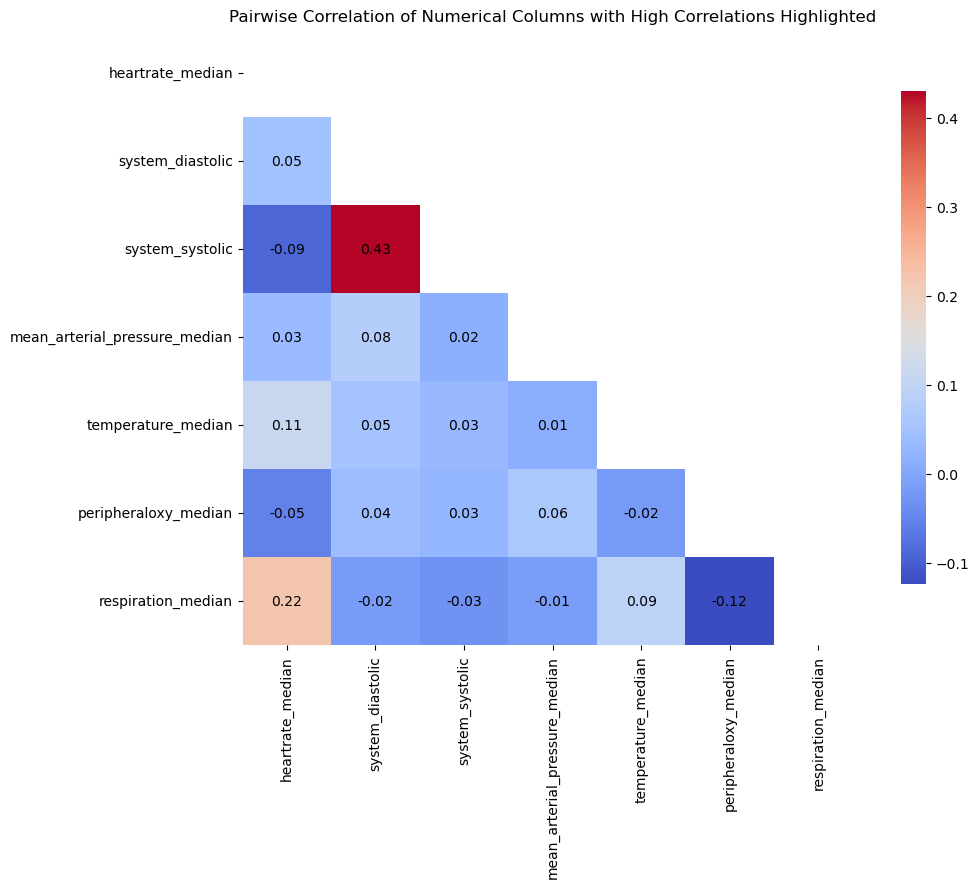

In [23]:
# Calculate Spearman correlation matrix
correlation_matrix = df_corr.corr(method='spearman')

# Mask the upper triangle and the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix with custom annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})

# Custom function to annotate the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if not mask[i, j]:
            plt.text(j + 0.5, i + 0.5, f'{correlation_matrix.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black')
            
# Highlight cells with high correlation
threshold = 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', lw=3))

plt.title('Pairwise Correlation of Numerical Columns with High Correlations Highlighted')
plt.show()

* No correlation observed from the chart

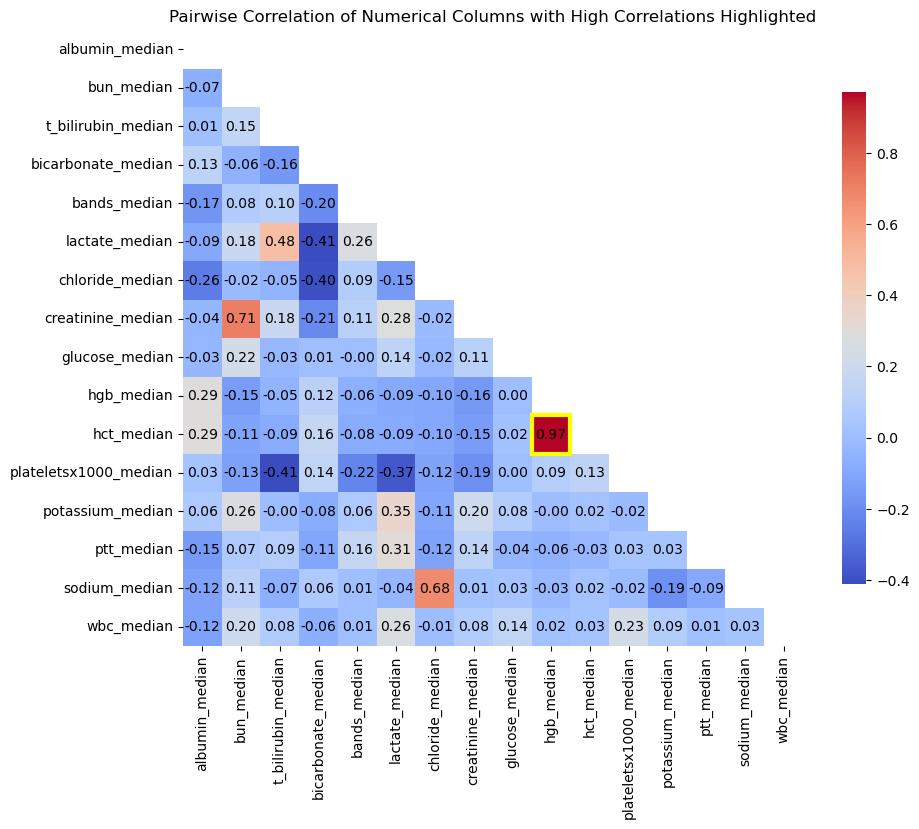

In [24]:
# Drop 'patientunitstayid' column from pivot_lab
df_corr = pivot_lab.drop(columns='patientunitstayid')

# Calculate Spearman correlation matrix
correlation_matrix = df_corr.corr(method='spearman')

# Plot correlation matrix
# Mask the upper triangle and the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix with custom annotations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', mask=mask, cbar_kws={'shrink': .8})

# Custom function to annotate the heatmap
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if not mask[i, j]:
            plt.text(j + 0.5, i + 0.5, f'{correlation_matrix.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black')
            
# Highlight cells with high correlation
threshold = 0.8
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) >= threshold:
            plt.gca().add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', lw=3))

plt.title('Pairwise Correlation of Numerical Columns with High Correlations Highlighted')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

<Figure size 1300x1000 with 0 Axes>

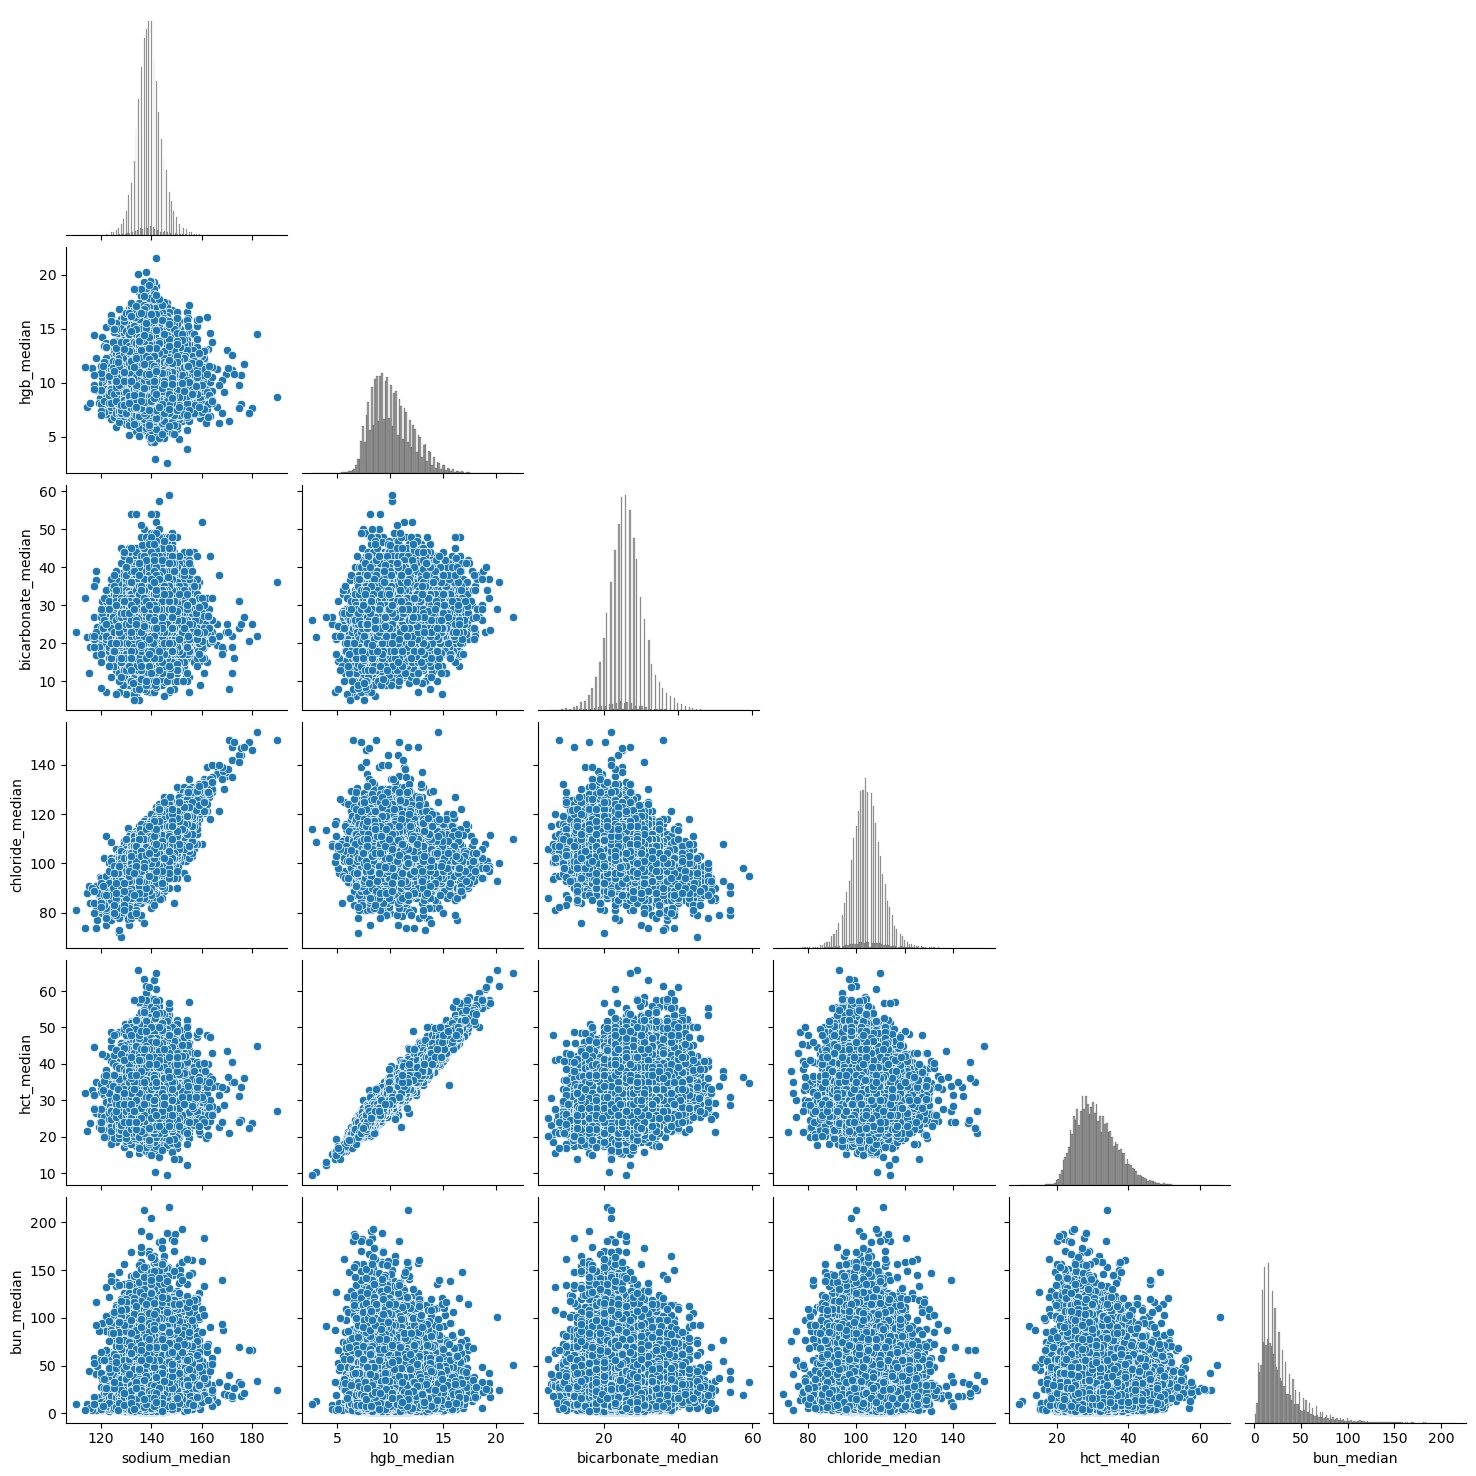

In [35]:
# Checking linear for those has high correlation
selected_cols = ['sodium_median','hgb_median','bicarbonate_median','chloride_median','hct_median','bun_median']
plt.figure(figsize=(13, 10))
sns.pairplot(pivot_lab[selected_cols],
             diag_kind='hist', corner=True, diag_kws={'color': 'grey'})
plt.yticks(rotation=0)
plt.show()

* There is a moderate, linear relation between sodium and Chloride value of the patient.
* Strong linear relation between hct and hgb since they are used to measure blood pressure.

So we will check VIF to reconfirm if there is any multicolinearity.

In [36]:
# Drop rows with NaN values in num_cols
lab_copy = pivot_lab[lab_cols].dropna()

# Add a constant column for VIF calculation
df_with_const = add_constant(lab_copy)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["feature"] = df_with_const.columns
vif["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]

# Drop the constant column from the results
vif = vif[vif["feature"] != "const"]

# Sort and display VIF
vif.sort_values(by='VIF', ascending=False, inplace=True)
print(vif)


                  feature        VIF
10             hgb_median  37.837085
11             hct_median  36.316040
7         chloride_median   7.835104
6          lactate_median   5.285687
15          sodium_median   5.076884
4      bicarbonate_median   4.116991
8       creatinine_median   4.008236
2              bun_median   3.772087
13       potassium_median   2.504681
12  plateletsx1000_median   2.198958
5            bands_median   1.945201
14             ptt_median   1.893441
16             wbc_median   1.874417
3      t_bilirubin_median   1.755933
9          glucose_median   1.617354
1          albumin_median   1.603002


Strong relation between hemoglobin and hematogrit which can be explained as those are used to measure the red blood cell content.

Lactate, sodium and chloride has moderate correlation. So can use PCA later to reduce the dimention.

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42661 entries, 0 to 42660
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   patientunitstayid              42661 non-null  int64  
 1   heartrate_median               42648 non-null  float64
 2   system_diastolic               16564 non-null  float64
 3   system_systolic                16565 non-null  float64
 4   mean_arterial_pressure_median  4275 non-null   float64
 5   temperature_median             8015 non-null   float64
 6   peripheraloxy_median           42386 non-null  float64
 7   respiration_median             40276 non-null  float64
 8   albumin_median                 13219 non-null  float64
 9   bun_median                     36734 non-null  float64
 10  t_bilirubin_median             11041 non-null  float64
 11  bicarbonate_median             34882 non-null  float64
 12  bands_median                   2238 non-null  

In [37]:
pd.set_option('display.max_columns', None)
display(df.head())

,patientunitstayid,heartrate_median,system_diastolic,system_systolic,mean_arterial_pressure_median,temperature_median,peripheraloxy_median,respiration_median,albumin_median,bun_median,t_bilirubin_median,bicarbonate_median,bands_median,lactate_median,chloride_median,creatinine_median,glucose_median,hgb_median,hct_median,plateletsx1000_median,potassium_median,ptt_median,sodium_median,wbc_median,age,gender,ethnicity,icu_duration_days,patient_status
0,141194,72.0,44.0,98.0,NaN,NaN,99.00,19.25,NaN,30.0,NaN,25.0,NaN,NaN,107.0,1.97,107.0,8.4,25.0,142.0,3.3,NaN,141.0,4.4,68,Male,Caucasian,3.342361,Alive
1,141233,88.0,56.0,99.0,40.0,36.6,97.50,20.75,NaN,23.0,NaN,25.0,NaN,NaN,100.0,0.84,96.0,NaN,NaN,NaN,4.1,NaN,134.0,NaN,81,Female,Caucasian,10.892361,Alive
2,141244,99.0,56.0,138.0,NaN,NaN,96.00,15.25,NaN,12.0,NaN,25.0,NaN,NaN,107.0,0.73,168.0,9.8,31.3,69.0,3.7,NaN,139.0,4.4,59,Male,Caucasian,2.663194,Alive
3,141265,88.5,NaN,NaN,NaN,NaN,91.00,25.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.1,42.9,157.0,NaN,31.0,NaN,8.8,67,Male,Caucasian,4.213889,Alive
4,141304,84.5,NaN,NaN,NaN,NaN,93.75,18.50,NaN,34.0,NaN,27.0,NaN,NaN,107.0,1.24,187.0,8.5,27.6,233.0,4.0,NaN,143.0,12.6,70,Male,Caucasian,4.610417,Alive


In [38]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

lactate_median                   95.464241
bands_median                     94.753991
mean_arterial_pressure_median    89.979138
ptt_median                       89.050890
temperature_median               81.212349
t_bilirubin_median               74.119219
albumin_median                   69.013853
system_diastolic                 61.172968
system_systolic                  61.170624
plateletsx1000_median            18.839221
wbc_median                       18.557933
bicarbonate_median               18.234453
hgb_median                       17.404655
hct_median                       17.371838
glucose_median                   14.188603
bun_median                       13.893251
creatinine_median                13.738543
chloride_median                  13.602588
sodium_median                    13.229882
potassium_median                 11.823445
respiration_median                5.590586
peripheraloxy_median              0.644617
heartrate_median                  0.030473
patient_sta

Now df is ready for scaling and go through feature reduction before modeling

In [40]:
# Save cleaned_df to a new CSV file
df.to_csv('cleaned_data.csv', index=False)